In [2]:
# Module import
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Import Module from torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential
from torch.nn import LeakyReLU
from torch.nn import Module
from torch.distributions import Normal

# Import Module from mlss2019bdl
from mlss2019bdl import fit
from mlss2019bdl import predict
from mlss2019bdl import dataset_from_numpy


In [3]:
# Utilize GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Generate the dataset
The dataset ranges in x-axis: [-10,-5] $\cup$ [5,10]   
The y should be a straight line, which means y = x.   
However, the `Aleatoric Uncertainty` is add to the value of y to make it closer to reality.     
The dataset have such a range so that the `Epistemic Uncertainty` would appear at: [-$\infty$, -10] $\cup$ [-5,5] $\cup$ [10, $\infty$].  

In [4]:
# Generate dataset about x axis value
array1 = np.linspace(-10, -5, num=501)[:, np.newaxis]
array2 = np.linspace(5, 10, num=501)[:, np.newaxis]
X_train = np.vstack((array1, array2))
# print(X_train)

# Generate dataset about y axis value
Gaussian_noise = np.random.normal(0, .5, X_train.shape) # gaussian noise with sigma = 0.5
y_train = X_train + Gaussian_noise
# print(y_train)

# Merge the dataset
train = dataset_from_numpy(X_train, y_train, device=device)

In [5]:
# Define the domain of function 
X_domain = np.linspace(-15., +15., num=301)[:, np.newaxis]
lower_bound = X_domain-1.96*0.5
upper_bound = X_domain+1.96*0.5
domain = dataset_from_numpy(X_domain, device=device)

# NN Model
Define a simple NN model with 3-layer fully connected and LeakyReLU activations, then training. 

In [6]:
# Define the NN model
model = Sequential(
    Linear(1, 512, bias=True),
    LeakyReLU(),

    Linear(512, 512, bias=True),
    LeakyReLU(),

    Linear(512, 1, bias=True),
)

model.to(device)

# Training and Prediction
fit(model, train, criterion="mse", n_epochs=2000, verbose=True, weight_decay=1e-3)
y_pred = predict(model, domain)

100%|██████████| 2000/2000 [01:23<00:00, 23.86it/s]


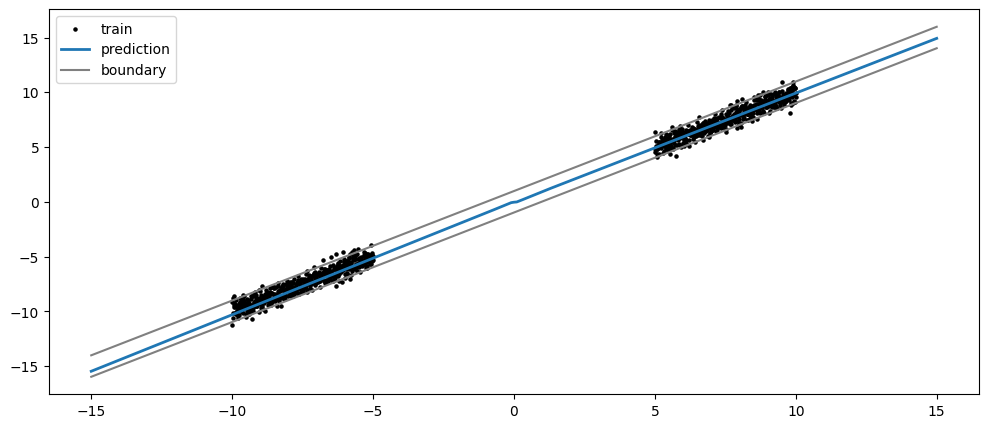

In [8]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.scatter(X_train, y_train, c="black", s=5, label="train")
ax.plot(X_domain, y_pred.numpy(), c="C0", lw=2, label="prediction")
ax.plot(X_domain, lower_bound, color='gray', label="boundary")
ax.plot(X_domain, upper_bound, color='gray')
plt.legend()